# Forecasting Air Passenger using CNN and GRU
1. In this exercise we will use **CNN and LSTM** for forecasting air passengers.
2. CNN+GRU modeling building, forecasting and result interpretation.

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.models import Input, Model, Sequential
from keras.layers import Dense, Flatten, GRU
from keras.layers import Conv1D, MaxPooling1D, TimeDistributed
from keras import losses
from keras import optimizers
from keras import callbacks

# perosnal wrapper created for time-series plots
import ts_utils

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

In [3]:
warnings.filterwarnings("ignore")

## Basic analysis and data preparation

In [4]:
DATADIR = '../data/air-passenger/'
data_path = os.path.join(DATADIR, 'AirPassengers.csv')

LOGDIR = '../checkpoints/air-passenger/ConvGRU/logs/'
MODELDIR = '../checkpoints/air-passenger/ConvGRU/logs/'

In [5]:
df = pd.read_csv(data_path, usecols=[1], header=0, engine='python')
data = df.values
data = data.astype('float32')

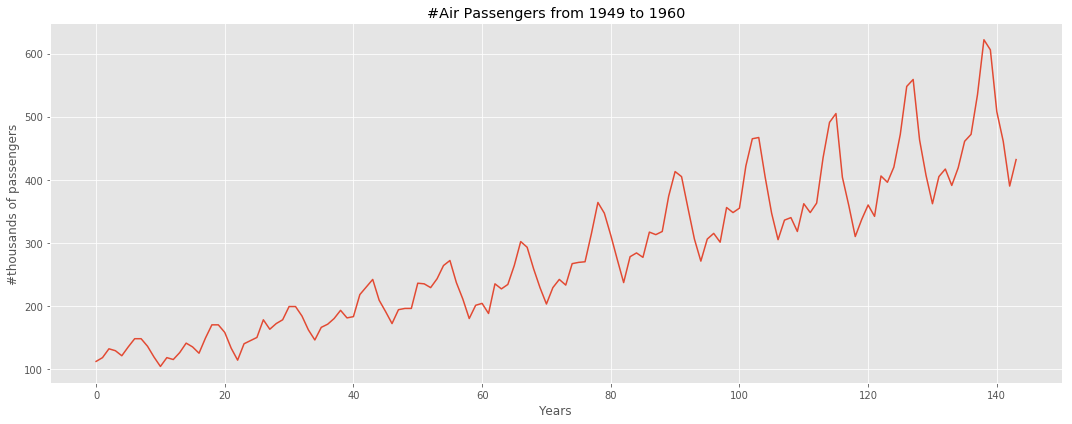

In [6]:
plt.plot(data)
plt.title('#Air Passengers from 1949 to 1960')
plt.ylabel('#thousands of passengers')
plt.xlabel('Years')
plt.tight_layout()
plt.show()

In [7]:
# ANNs are sensitive to the scale of the input data.
# So, for our analysis we will limit the data magnitude to (0, 1)

# scalar transformation
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scalar.fit_transform(data)

train, test = train_test_split(scaled_data, train_size=0.8 ,shuffle=False)

len(train), len(test)

X_train, y_train = ts_utils.prepare_data(train, time_step=3)
X_test, y_test = ts_utils.prepare_data(test, time_step=3)

# The length of data will be reduced 
# by the amount of time step (when time_step=1)
len(X_train), len(X_test)

# lets see some sample data
print(f'Independent variable values t: \n{X_train[:5, :]}')
print(f'Depending variable values t+1: \n{y_train[:5]}')

Independent variable values t: 
[[0.01544401 0.02702703 0.05405405]
 [0.02702703 0.05405405 0.04826255]
 [0.05405405 0.04826255 0.03281853]
 [0.04826255 0.03281853 0.05984557]
 [0.03281853 0.05984557 0.08494207]]
Depending variable values t+1: 
[[0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]]


## ConvGRU model building and training

In [8]:
# Usually, CNN needs the input in the form of [#samples, features]
# but for time-series we will tranform the input in the form of [#samples, time step, input_dims/features]
# so, timesteps = 3, and as there is only one variable we will use features = 1
timesteps = 3
features = 1
batch_size = None

X_train = np.reshape(X_train, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, features))

print(X_train.shape)

(111, 3, 1)


In [9]:
# We will build the model with 2 consecutive CONV layers then MaxPooling, Dense layer and output layer.
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=2, activation='relu', name='conv1', input_shape=(3, 1)))
model.add(MaxPooling1D(pool_size=2, name='pool1'))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu', name='conv2'))
model.add(GRU(16, activation='tanh', name='lstm'))
model.add(Dense(1, name='output'))

model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 2, 16)             48        
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 1, 16)             0         
_________________________________________________________________
conv2 (Conv1D)               (None, 1, 32)             544       
_________________________________________________________________
lstm (GRU)                   (None, 16)                2352      
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 2,961
Trainable params: 2,961
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compile the model
model.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam())

In [11]:
# checkpoint directory for saving model weights
if os.path.exists(LOGDIR):
    pass
else:
    os.makedirs(LOGDIR)
    
# model directory
if os.path.exists(MODELDIR):
    pass
else:
    os.makedirs(MODELDIR)

In [12]:
callbacks_list = [callbacks.TensorBoard(log_dir=LOGDIR)]

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=1, 
                    verbose=0,
                    shuffle=False,
                    callbacks = callbacks_list
                   )


model.save(os.path.join(MODELDIR, 'conv_gru_v1.h5'))
model.save_weights(os.path.join(MODELDIR, 'conv_gru_weight_v1.h5'))

Instructions for updating:
Use the retry module or similar alternatives.


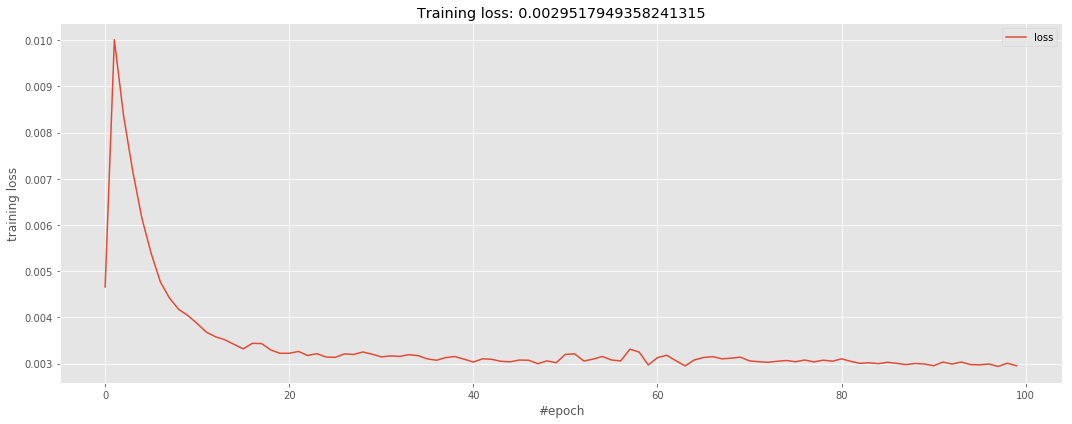

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.ylabel("training loss")
plt.xlabel("#epoch")
plt.title("Training loss: {}".format(history.history["loss"][-1]))
plt.legend()
plt.tight_layout()
plt.show()

## Prediction and result evaluation

In [14]:
# prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# the results are in the form of scaled value, so inverse the transformation
y_train_pred_inv = scalar.inverse_transform(y_train_pred)
y_test_pred_inv = scalar.inverse_transform(y_test_pred)

# will be used for calculating MAE and MSE
y_train_inv = scalar.inverse_transform(y_train)
y_test_inv = scalar.inverse_transform(y_test)

# MAE and RMSE calculation
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
train_mae = mean_absolute_error(y_train_inv, y_train_pred_inv)
train_nrmse = train_rmse/np.std(y_train_inv)

test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
test_mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
test_nrmse = test_rmse/np.std(y_test_inv)

print(f'Training NRMSE: {train_nrmse}')
print(f'Training MAE: {train_mae}')

print(f'Test NRMSE: {test_nrmse}')
print(f'Test MAE: {test_mae}')

Training NRMSE: 0.5446258187294006
Training MAE: 39.34639358520508
Test NRMSE: 0.6785717010498047
Test MAE: 43.76695251464844


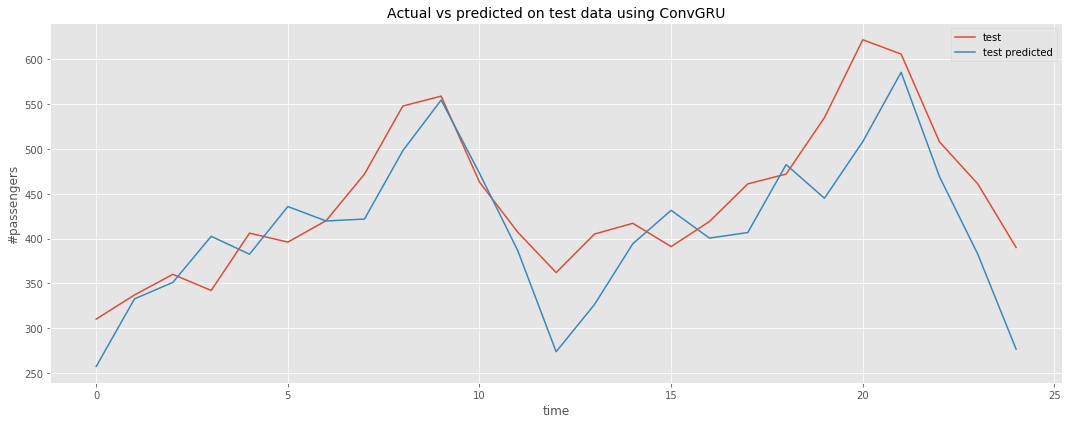

In [15]:
plt.plot(y_test_inv, label='test')
plt.plot(y_test_pred_inv, label='test predicted')
plt.ylabel('Sales')
plt.xlabel('time')
plt.ylabel('#passengers')
plt.title('Actual vs predicted on test data using ConvGRU', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

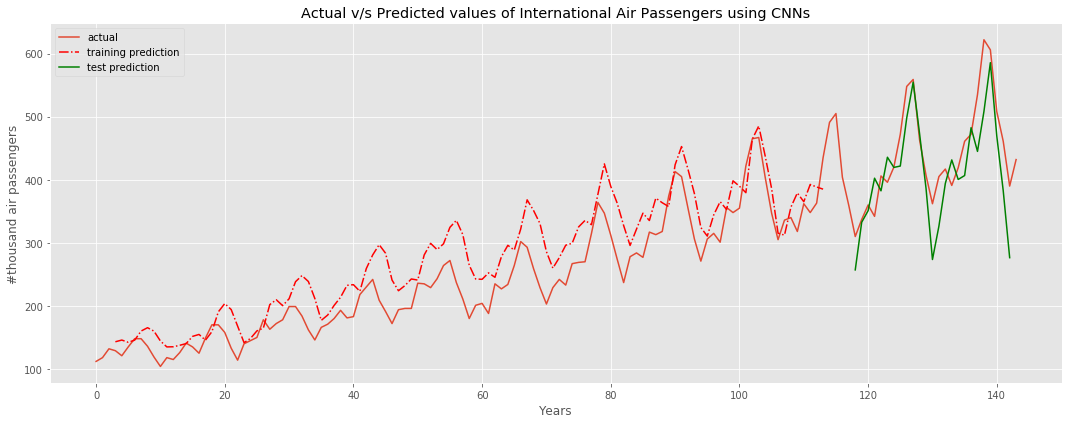

In [16]:
# plotting the results and comparison

# the prediction for LSTM will be shifted by the value of time_steps
# as 't' is used to calculate the value of 't+1', so plotting start from 't+1'
time_step=3

train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[time_step:len(y_train_pred_inv)+time_step, :] = y_train_pred_inv

# shift test predictions for plotting
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(y_train_pred_inv)+(time_step*2)+1:len(data)-1, :] = y_test_pred_inv

# result plotting
plt.plot(data, label='actual')
plt.plot(train_plot, color='red', linestyle='-.', label='training prediction')
plt.plot(test_plot, color='green', linestyle='-', label='test prediction')
plt.xlabel('Years')
plt.ylabel('#thousand air passengers')
plt.title('Actual v/s Predicted values of International Air Passengers using CNNs')

plt.legend()
plt.tight_layout()
plt.show()

## Conclusion and result interpretation


- Training RMSE: 44.853370666503906
- Training MAE: 36.511451721191406
- Test RMSE: 51.67366027832031
- Test MAE: 42.819515228271484